<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    SAN Projekt:<br> Schweizer Offshore Firmen
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Tobias Buess im FS 2024.
</p>

Wir führen eine Voranalyse für das Bundesamt für Statistik durch, um die kürzlich aufgetretenen Leaks aus den Offshore Papers zu untersuchen. 

Diese Analyse zielt darauf ab, Umfang und Natur der Verbindungen in Schweizer Offshore-Strukturen zu ermitteln. Wir verwenden dafür Daten aus der [Offshore Leaks Database](https://offshoreleaks.icij.org/), um mögliche Muster, wichtige Personen aufzudecken, die für die Steuerbehörden oder Regulierungsorgane von Interesse sein könnten. 

Unsere Arbeit umfasst eine detaillierte Prüfung der betroffenen Entitäten. Dies wird es dem Bundesamt für Statistik ermöglichen, fundierte Entscheidungen zur weiteren Untersuchung und möglichen Massnahmen zu treffen.

## Inhalt
1. Wie sehen die Daten aus? Was für Informationen können wir daraus ziehen?
2. Grobe Metriken zu Schweizer Officers und deren Offshore Firmen.
3. ...

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re

# read data

In [2]:
entityNodes = pd.read_csv("./data/nodes-entities.csv", low_memory=False, index_col=0)
entityNodes["node_type"] = ["Entity"] * len(entityNodes)

intermediaryNodes = pd.read_csv(
    "./data/nodes-intermediaries.csv", low_memory=False, index_col=0
)
intermediaryNodes["node_type"] = ["Intermediary"] * len(intermediaryNodes)

officerNodes = pd.read_csv("./data/nodes-officers.csv", low_memory=False, index_col=0)
officerNodes["node_type"] = ["Officer"] * len(officerNodes)

relationships = pd.read_csv("./data/relationships.csv", low_memory=False).set_index(
    ["node_id_start", "node_id_end"]
)

In [3]:
# filter active entities
activeEntities = entityNodes[entityNodes["status"] == "Active"].reset_index()

# get all shareholders
shareholder_relations = relationships[
    relationships.link == "shareholder of"
].reset_index()

# get all swiss officers
officerNodes.countries = officerNodes.countries.fillna("")
swiss_officers = officerNodes[
    officerNodes.countries.str.contains("Switzerland")
].reset_index()

# join all active entities with swiss officers
entities_with_swiss_officers = pd.merge(
    shareholder_relations,
    swiss_officers,
    left_on="node_id_start",
    right_on="node_id",
    how="inner",
    suffixes=("_relation", "_officer"),
)
entities_with_swiss_officers = pd.merge(
    entities_with_swiss_officers,
    activeEntities,
    left_on="node_id_end",
    right_on="node_id",
    how="inner",
    suffixes=("_officer", "_entity"),
)

# clean up
filtered_entities_with_swiss_officers = entities_with_swiss_officers[
    [
        "node_id_officer",
        "node_id_entity",
        "name_officer",
        "name_entity",
        "countries_officer",
        "countries_entity",
        "start_date",
        "incorporation_date",
        "status_entity",
        "rel_type",
        "link",
    ]
]
filtered_entities_with_swiss_officers

node_id_officer  node_id_entity  \
0            12007826        10023457   
1            12010786        10106960   
2            12148294        10106960   
3            12010807        10126417   
4            12011893        10044735   
...               ...             ...   
3478            56420          159752   
3479            53050          146982   
3480            59047          162130   
3481            59581          162249   
3482            59696          141587   

                                           name_officer  \
0                                Per Karl Martin Tonnby   
1     NWT SERVICES LIMITED(formerly NWT Nominess Lim...   
2                                    LOMBARD TRUST S.A.   
3                                            PENONI LTD   
4                                    Mr. Rigas PERDIKIS   
...                                                 ...   
3478                                        Cyril Ratel   
3479                                  STEFANO MENEGALLI   
3480                                         Yves Leyss   
3481                                 Roberto Villasanta   
3482                                   Raphael Ramseyer   

                                  name_entity countries_officer  \
0                  Riverlake Holdings Limited       Switzerland   
1                           RANDA TWO LIMITED       Switzerland   
2                           RANDA TWO LIMITED       Switzerland   
3                 ODDASEA INVESTMENTS LIMITED       Switzerland   
4                    DARLASTON RESOURCES INC.       Switzerland   
...                                       ...               ...   
3478                HABILE MIND GROUP LIMITED       Switzerland   
3479       Tower Bay Investments Holdings Ltd       Switzerland   
3480  International Fintrade Services Limited       Switzerland   
3481                   Lucky 8 Consulting Ltd       Switzerland   
3482            Atlantic Alliance Group, Ltd.       Switzerland   

            countries_entity   start_date incorporation_date status_entity  \
0              Liechtenstein  15-JUN-2009        04-MAR-2008        Active   
1                   Zimbabwe  05-OCT-2015        20-MAY-2003        Active   
2                   Zimbabwe  04-JUL-2003        20-MAY-2003        Active   
3                Switzerland  02-JAN-2007        02-JAN-2007        Active   
4                Switzerland  06-NOV-2015        06-OCT-2006        Active   
...                      ...          ...                ...           ...   
3478  British Virgin Islands   2009-02-09        08-OCT-2008        Active   
3479  British Virgin Islands   2005-11-30        28-OCT-2005        Active   
3480              Seychelles   2006-03-10        10-MAR-2006        Active   
3481  British Virgin Islands   2006-05-29        28-APR-2006        Active   
3482  British Virgin Islands   2004-03-22        22-MAR-2004        Active   

        rel_type            link  
0     officer_of  shareholder of  
1     officer_of  shareholder of  
2     officer_of  shareholder of  
3     officer_of  shareholder of  
4     officer_of  shareholder of  
...          ...             ...  
3478  officer_of  shareholder of  
3479  officer_of  shareholder of  
3480  officer_of  shareholder of  
3481  officer_of  shareholder of  
3482  officer_of  shareholder of  

[3483 rows x 11 columns]

In [4]:
print(
    "Number of entities with swiss officers: ",
    len(filtered_entities_with_swiss_officers),
)

Number of entities with swiss officers:  3483


In [5]:
nodes_officers_new = filtered_entities_with_swiss_officers[
    ["node_id_officer", "name_officer", "countries_officer"]
].copy()
nodes_officers_new.columns = ["node_id", "name", "countries"]
nodes_officers_new["node_type"] = "Officer"

nodes_entities_new = filtered_entities_with_swiss_officers[
    [
        "node_id_entity",
        "name_entity",
        "countries_entity",
        "start_date",
        "incorporation_date",
        "status_entity",
    ]
].copy()
nodes_entities_new.columns = [
    "node_id",
    "name",
    "countries",
    "start_date",
    "incorporation_date",
    "status",
]
nodes_entities_new["node_type"] = "Entity"

relationships_new = filtered_entities_with_swiss_officers[
    ["node_id_officer", "node_id_entity", "rel_type", "link"]
].copy()
relationships_new.columns = ["node_id_start", "node_id_end", "rel_type", "link"]

In [6]:
G = nx.DiGraph()
G.add_nodes_from(
    [
        (officer["node_id"], officer)
        for officer in nodes_officers_new.to_dict("index").values()
    ],
    bipartite=0,
)
G.add_nodes_from(
    [
        (entity["node_id"], entity)
        for entity in nodes_entities_new.to_dict("index").values()
    ],
    bipartite=1,
)
G.add_edges_from(
    [
        (relation["node_id_start"], relation["node_id_end"], relation)
        for relation in relationships_new.to_dict("index").values()
    ]
)

color_map = {"Entity": "red", "Officer": "blue"}

print(
    "Number of officer nodes:",
    len([n for n, d in G.nodes(data=True) if d["node_type"] == "Officer"]),
)
print(
    "Number of entity nodes:",
    len([n for n, d in G.nodes(data=True) if d["node_type"] == "Entity"]),
)
print("Number of edges:", G.number_of_edges())

Number of officer nodes: 1802
Number of entity nodes: 2639
Number of edges: 3346


Entity with most connections: UKCP INVESTMENTS LIMITED with 50 connections


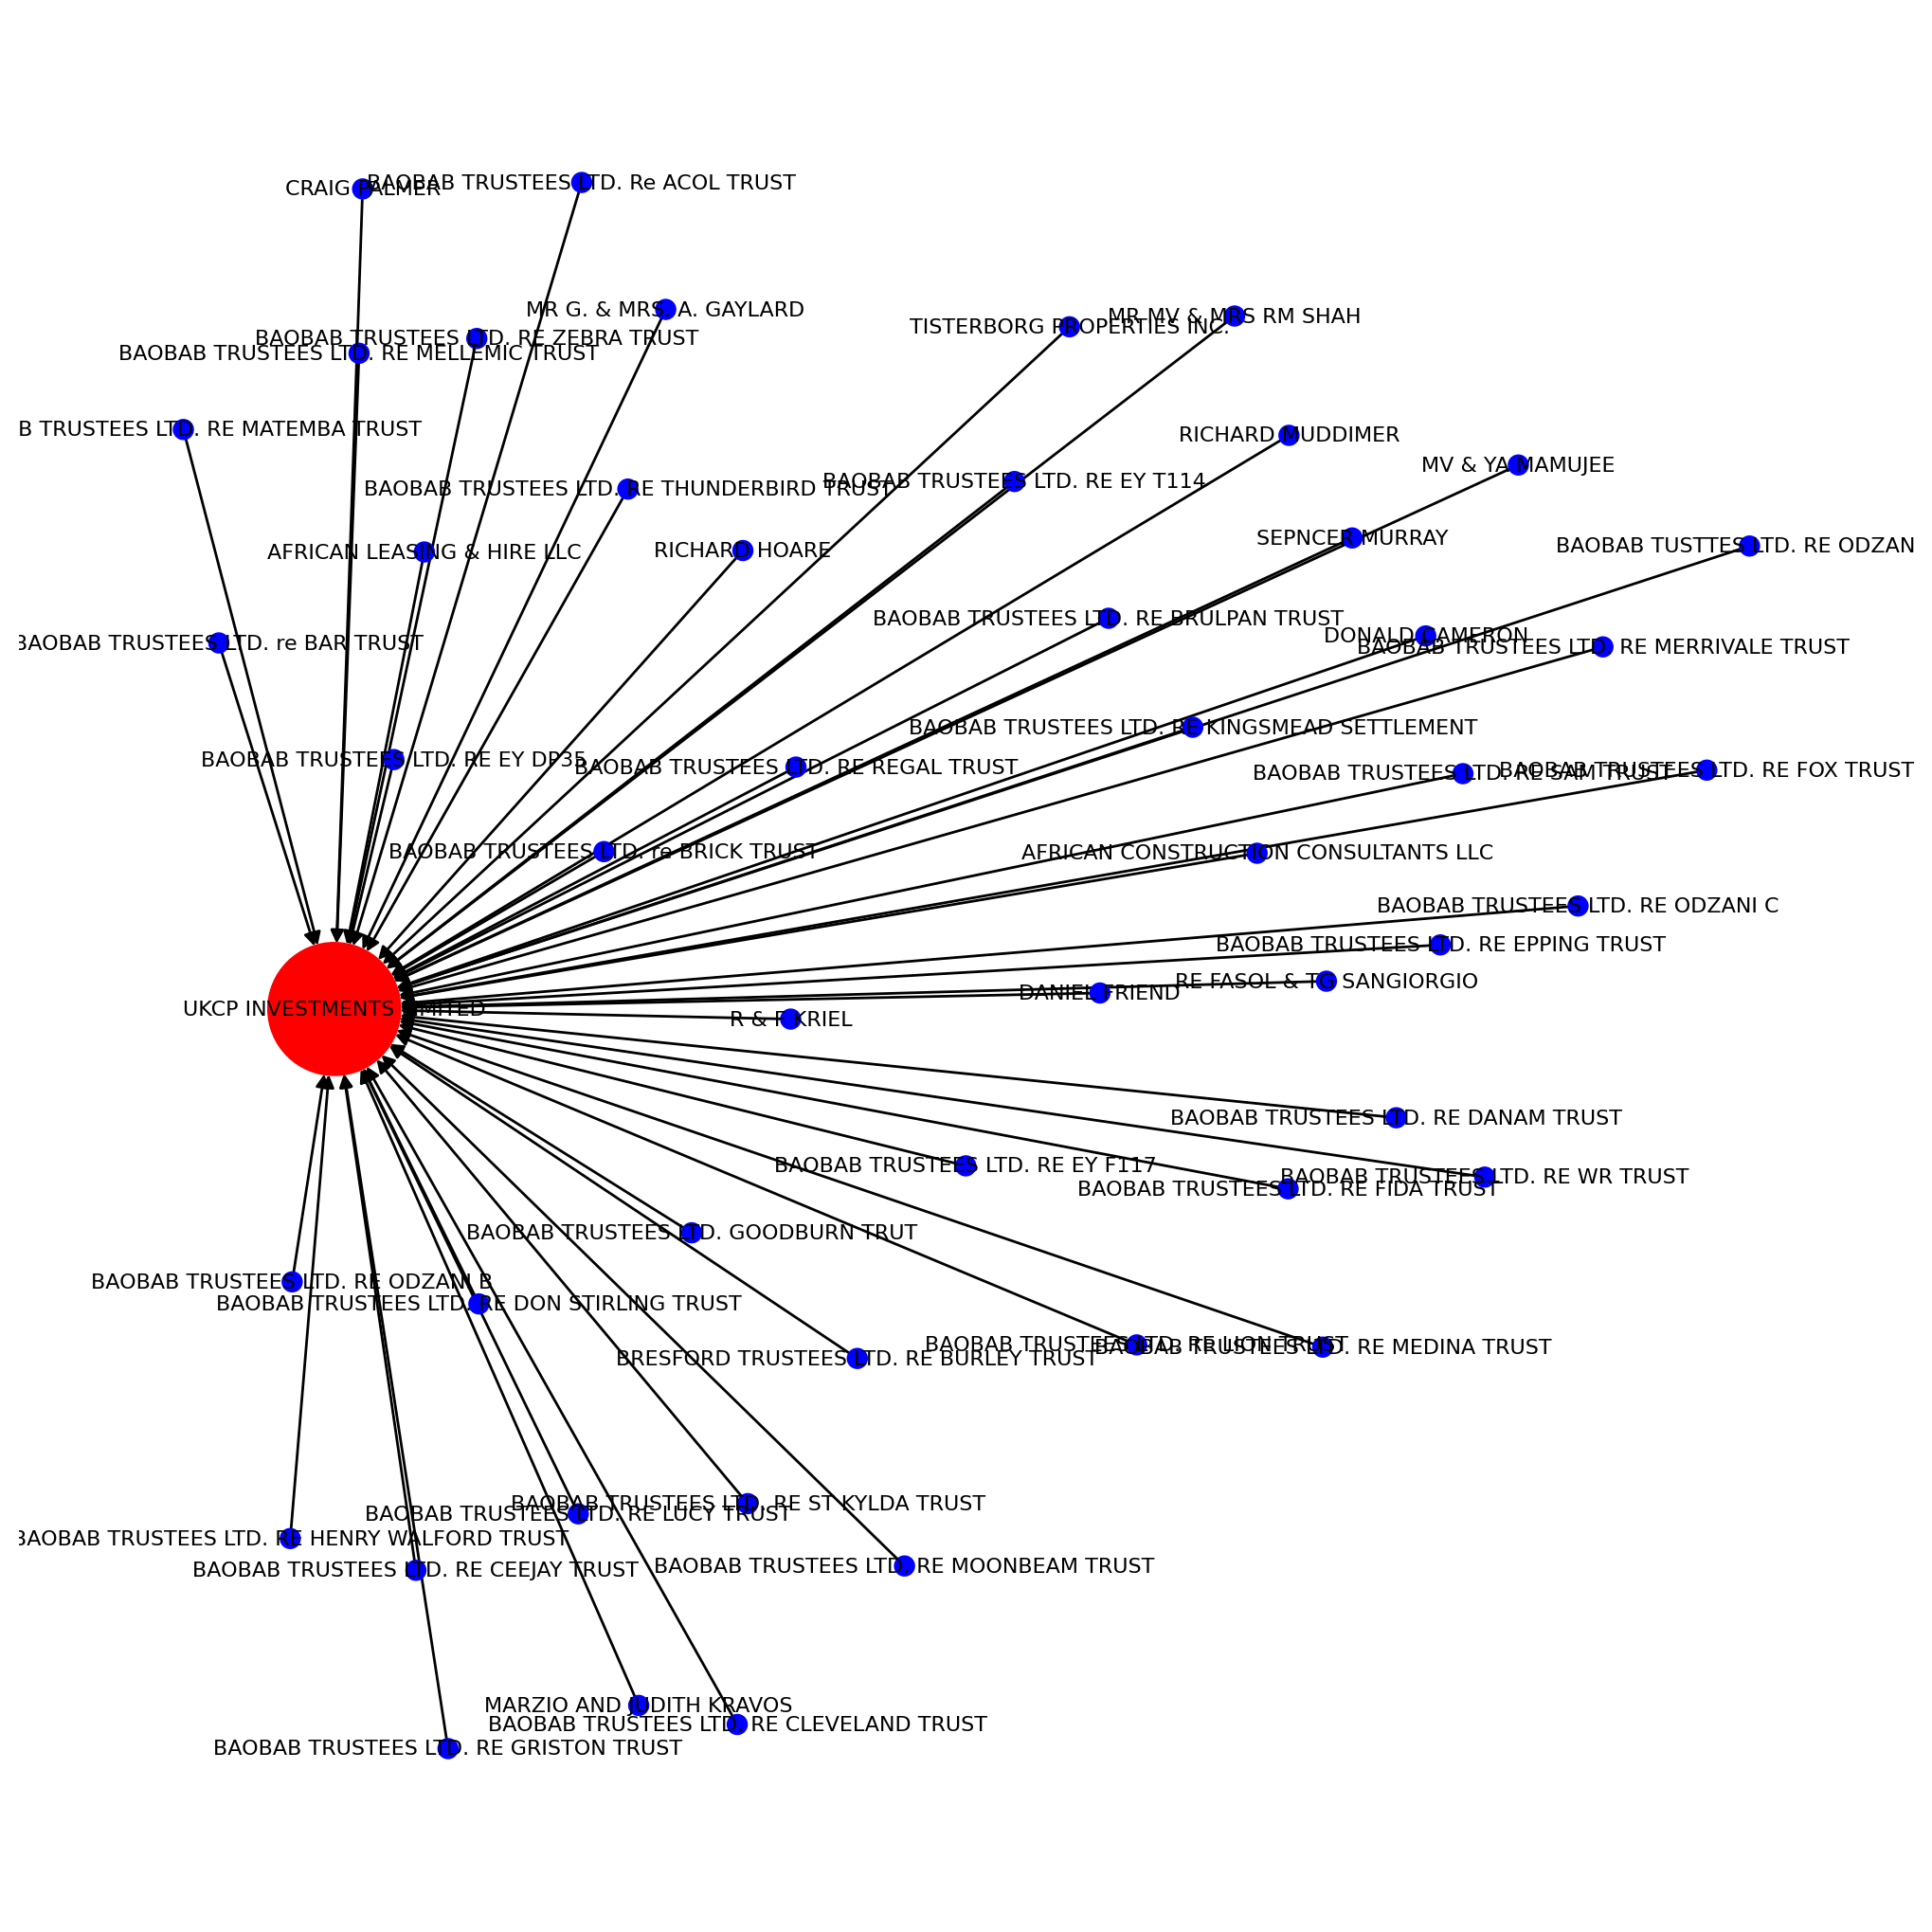

In [7]:
# get the entity with the most connections
entity_degrees = G.degree(nodes_entities_new["node_id"])
max_entity = max(entity_degrees, key=lambda x: x[1])
print(
    f"Entity with most connections: {G.nodes[max_entity[0]]['name']} with {max_entity[1]} connections"
)

# draw ego graph of entity with most connections
plt.figure(figsize=(10, 10), dpi=200)
ego_graph = nx.ego_graph(G, max_entity[0], radius=1, undirected=True)
colors = [color_map[G.nodes[node]["node_type"]] for node in ego_graph.nodes]
sizes = [G.degree[node] * 50 for node in ego_graph.nodes]
labels = {node: G.nodes[node]["name"] for node in ego_graph.nodes}
nx.draw(
    ego_graph,
    with_labels=True,
    node_color=colors,
    node_size=sizes,
    labels=labels,
    font_size=8,
)

Officer with most connections: Sharecorp Limited with 1098 connections


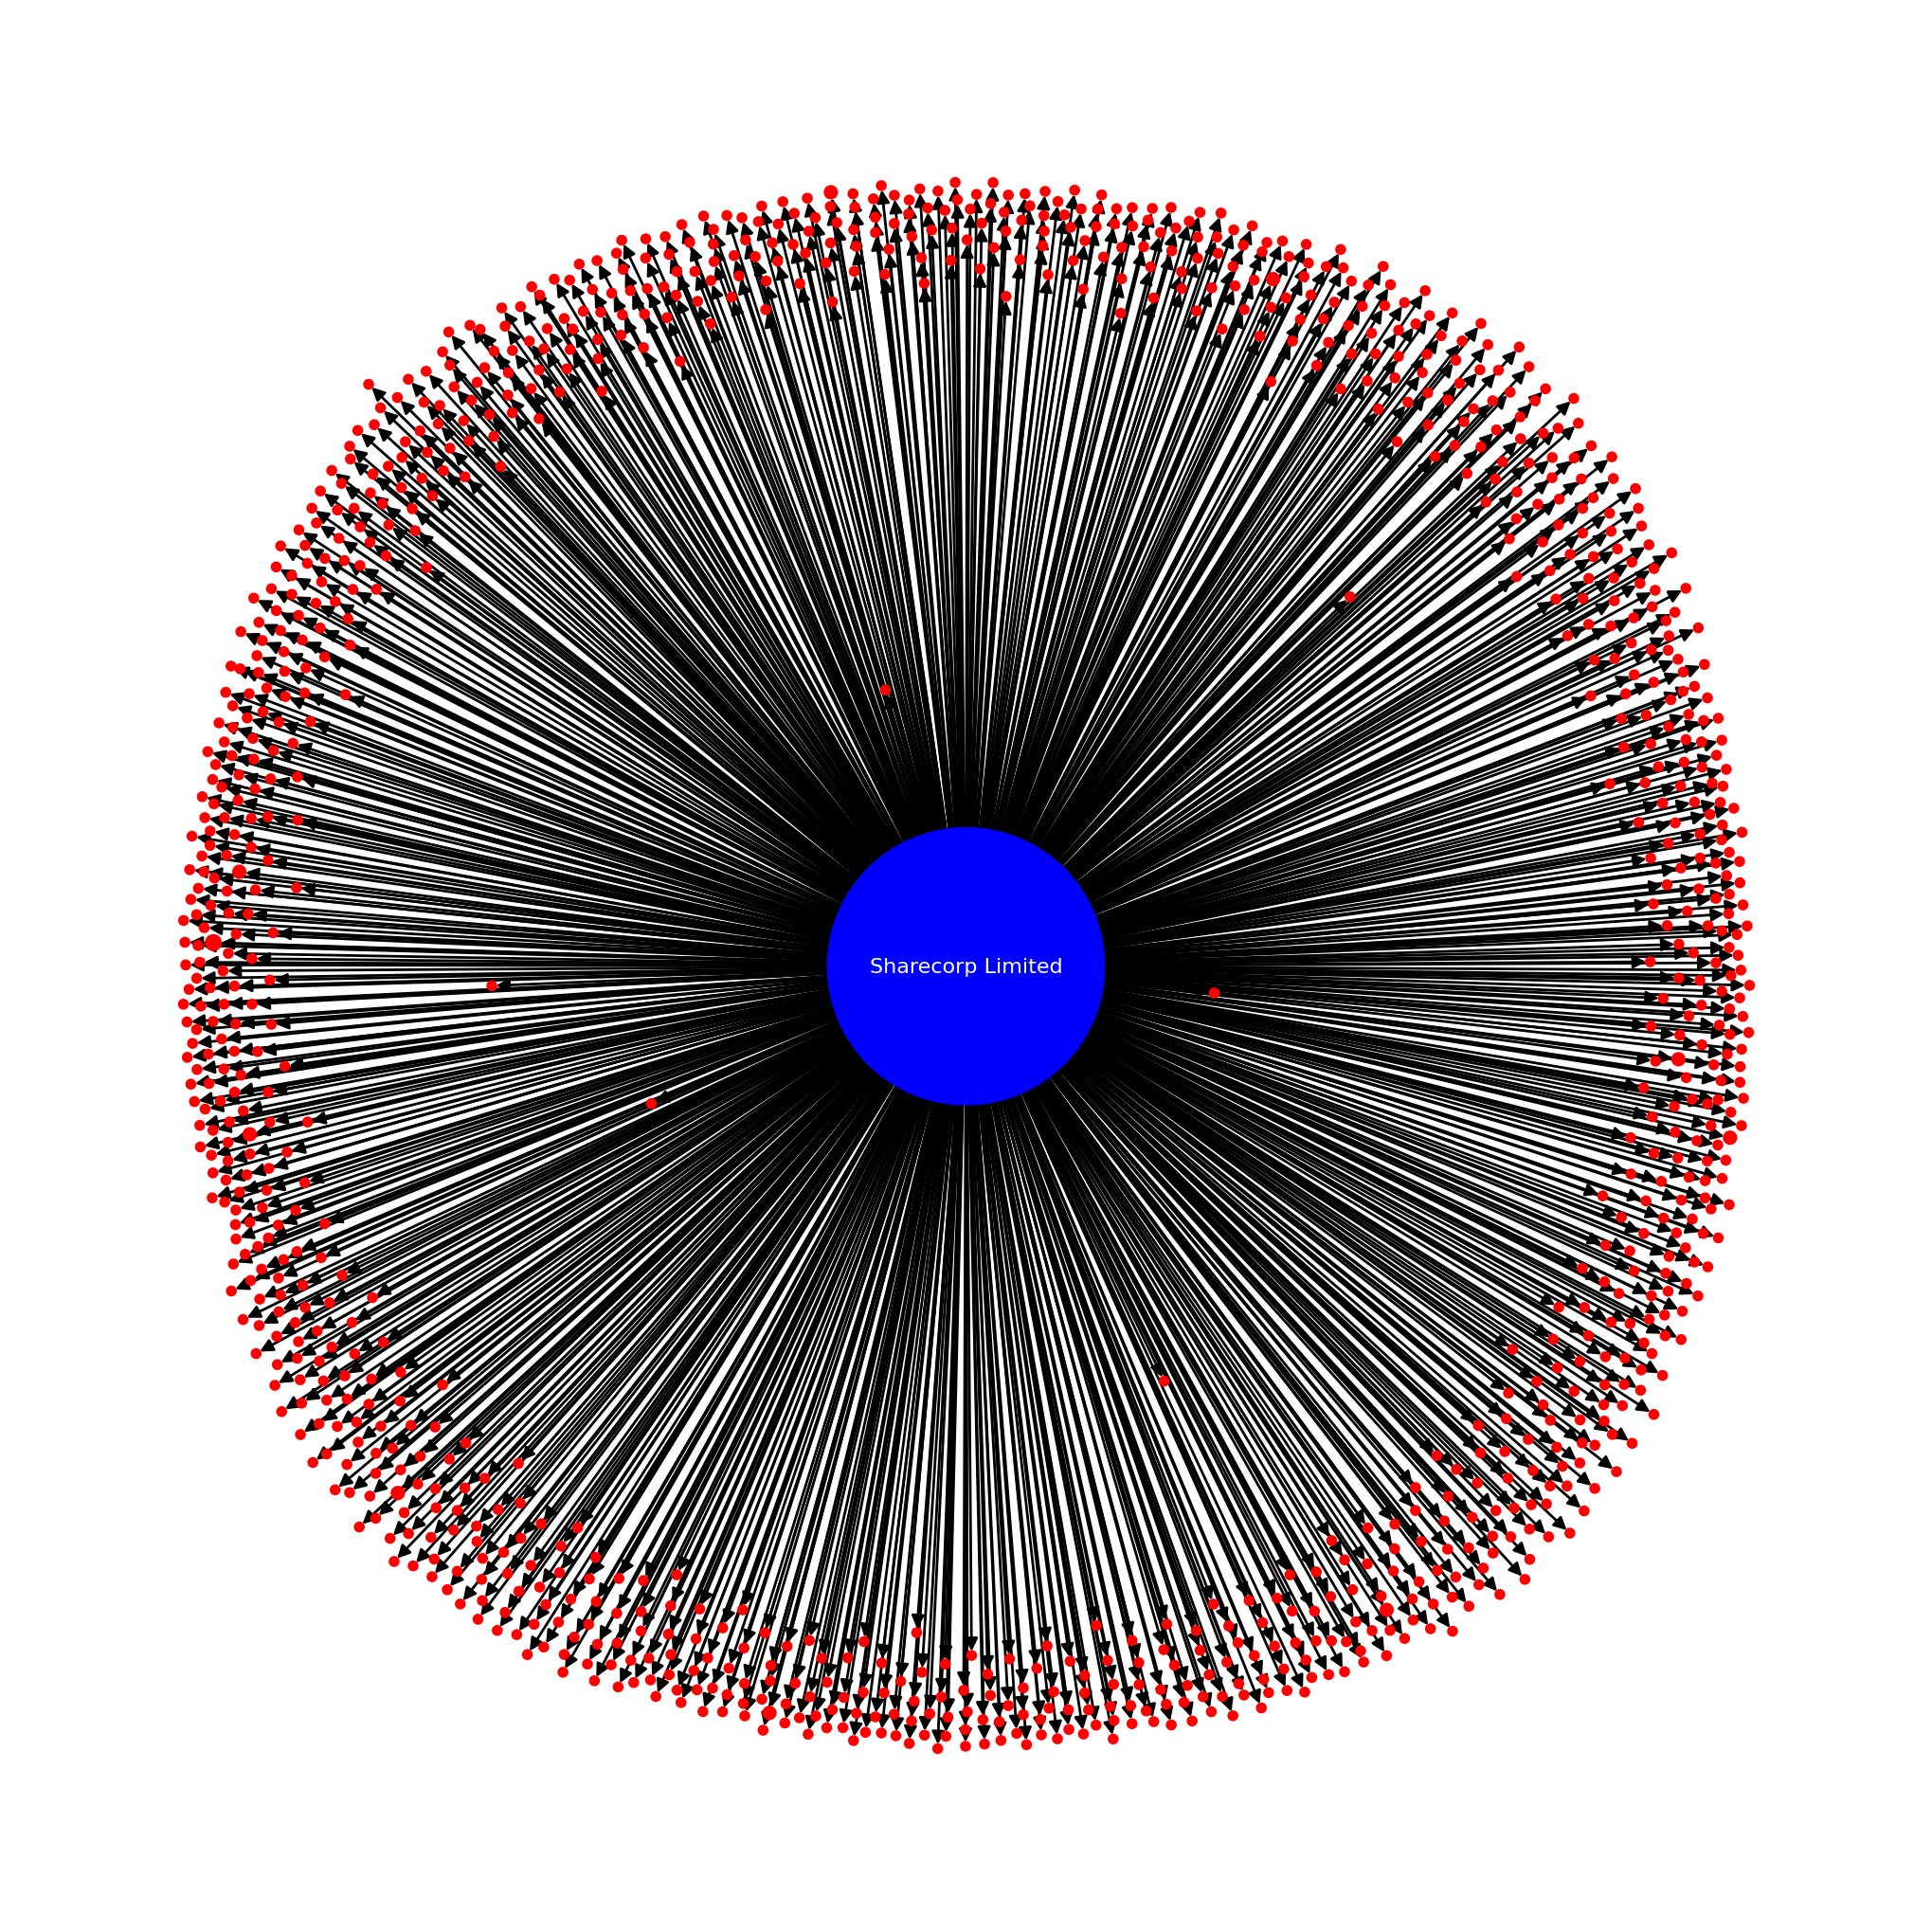

In [8]:
# get the officer with the most connections
officer_degrees = G.degree(nodes_officers_new["node_id"])
max_officer = max(officer_degrees, key=lambda x: x[1])
print(
    f"Officer with most connections: {G.nodes[max_officer[0]]['name']} with {max_officer[1]} connections"
)

# draw ego graph of officer with most connections
plt.figure(figsize=(10, 10), dpi=200)
ego_graph = nx.ego_graph(G, max_officer[0], radius=1)
colors = [color_map[G.nodes[node]["node_type"]] for node in ego_graph.nodes]
sizes = [G.degree(node) * 10 for node in ego_graph.nodes]
labels = {
    node: "" if node != max_officer[0] else G.nodes[node]["name"]
    for node in ego_graph.nodes
}
nx.draw(
    ego_graph,
    with_labels=True,
    node_color=colors,
    node_size=sizes,
    labels=labels,
    font_size=8,
    font_color="white",
)

Officer with most connections: MARZIO AND JUDITH KRAVOS with 49 connections


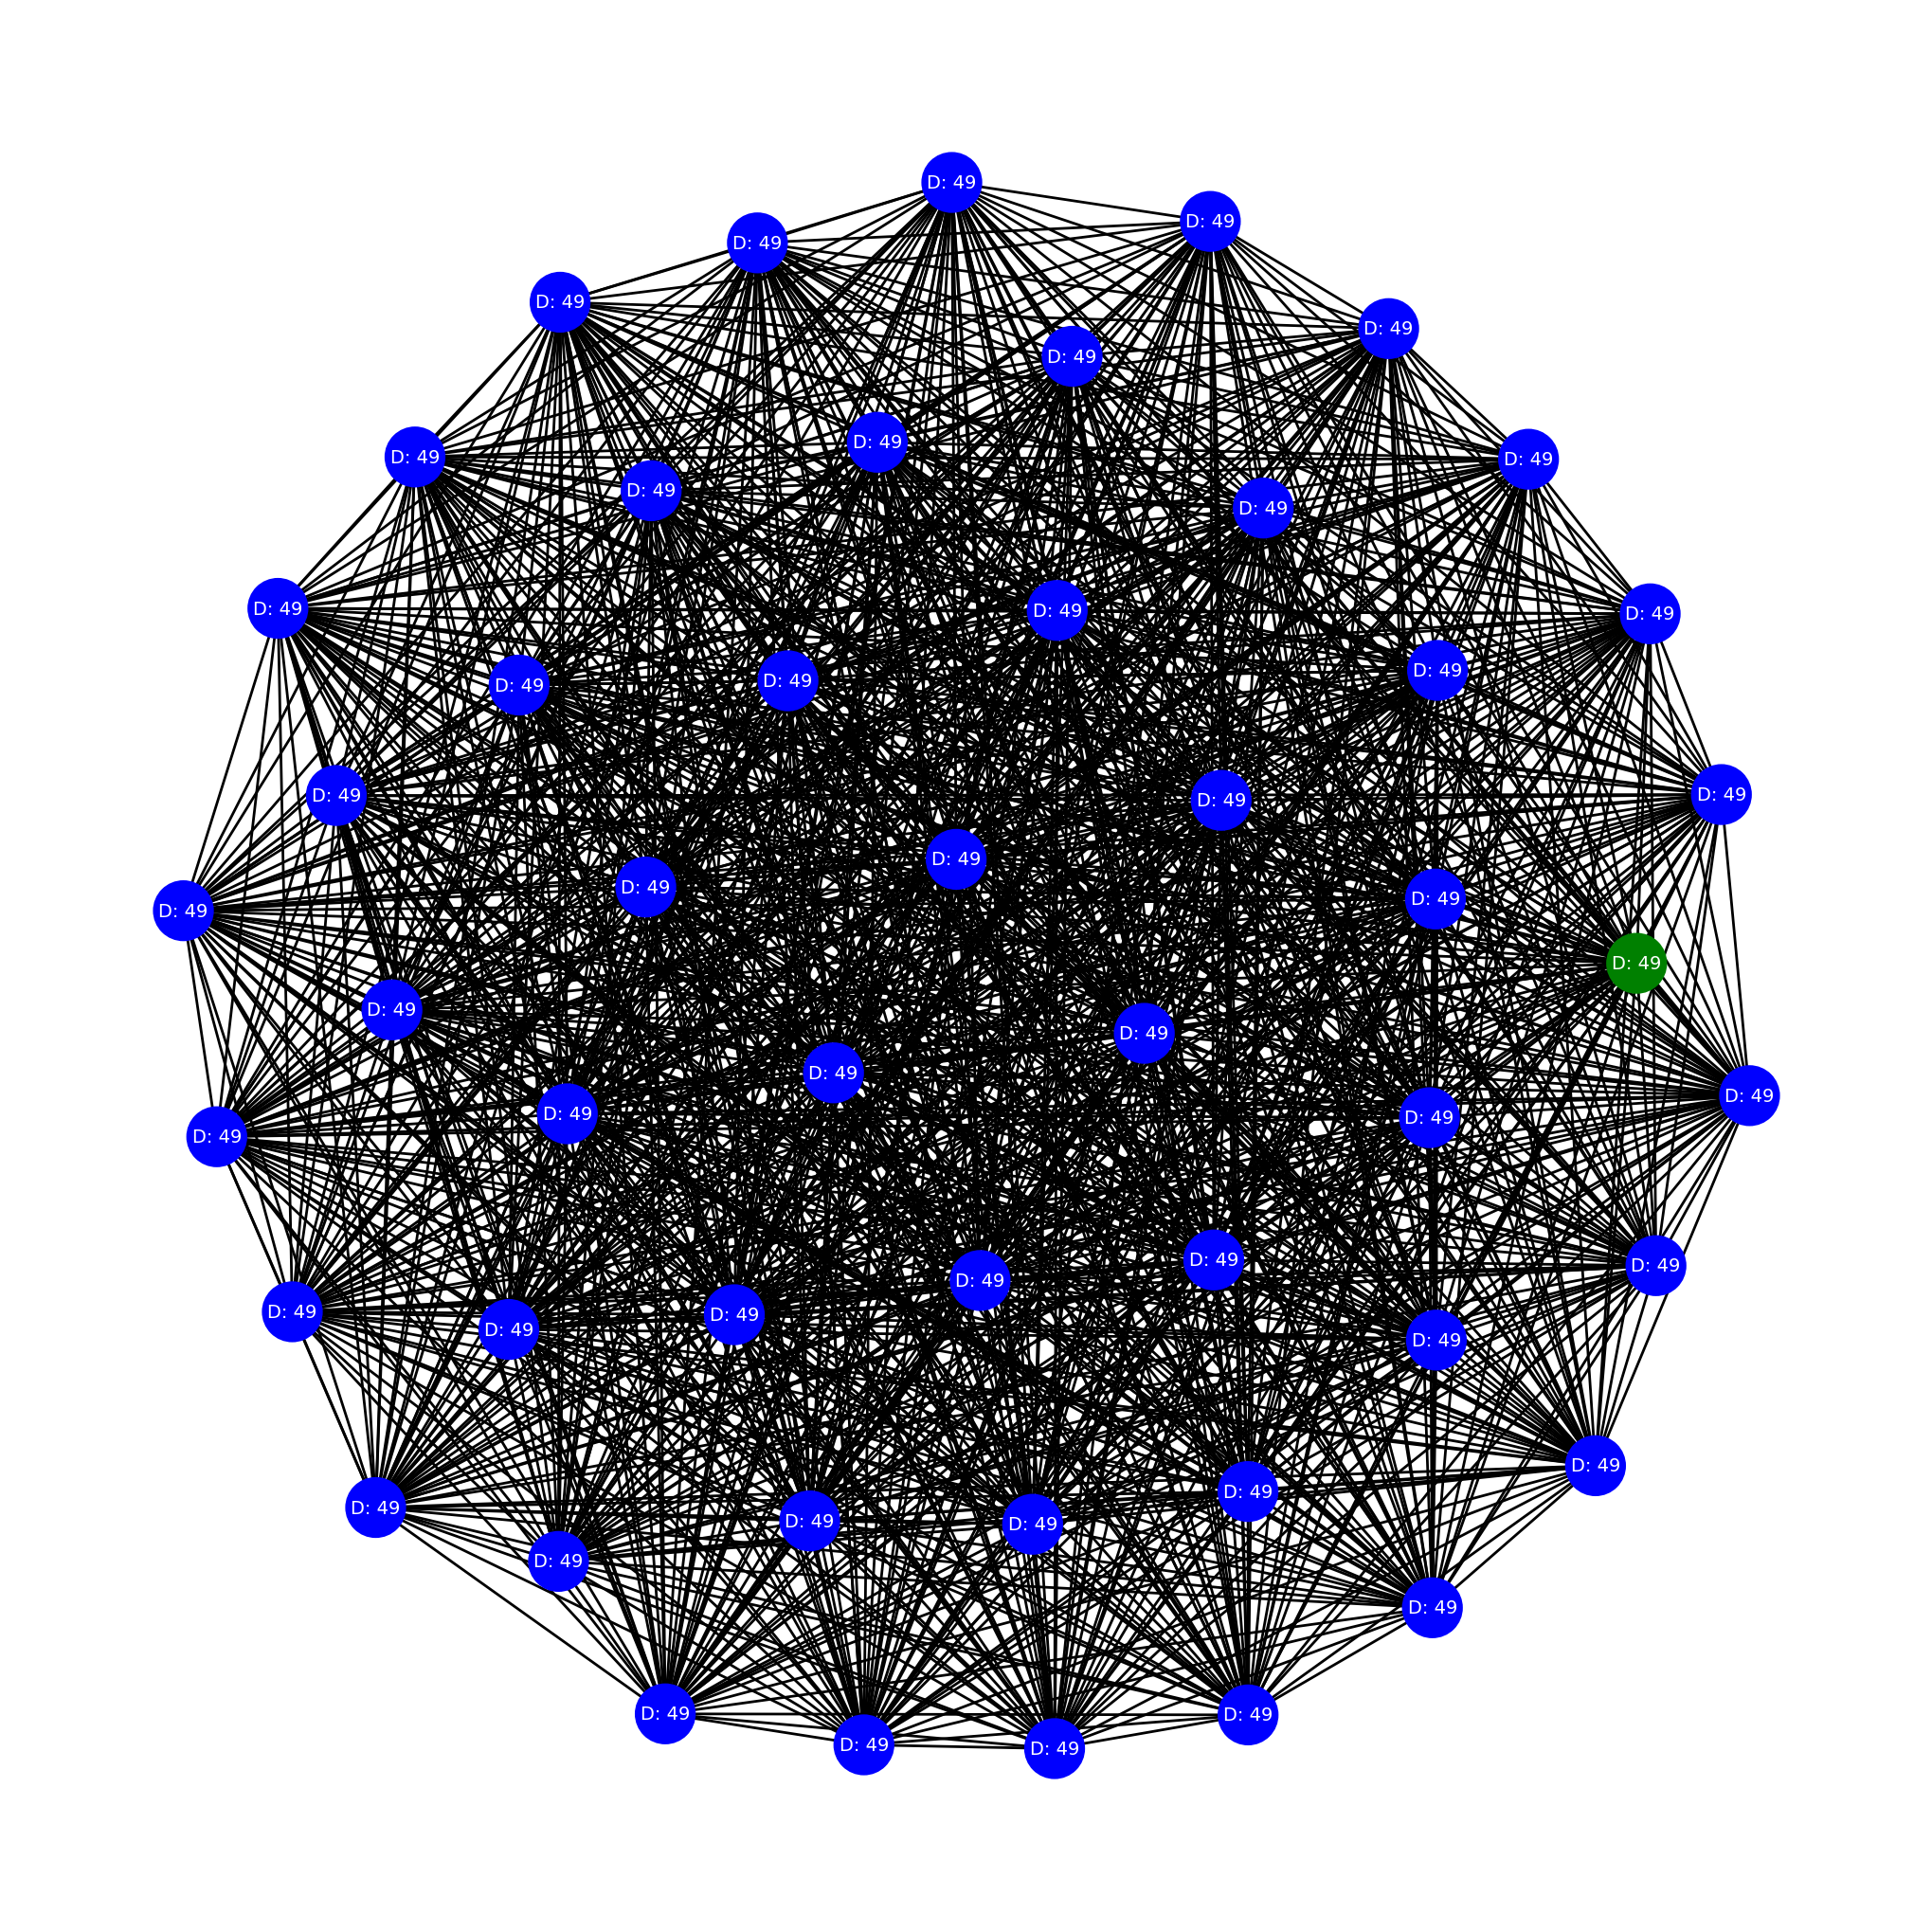

In [9]:
B = nx.bipartite.weighted_projected_graph(
    G.to_undirected(), nodes_officers_new["node_id"], ratio=True
)

# get the officer with the most connections
officer_degrees = B.degree(nodes_officers_new["node_id"])
max_officer = max(officer_degrees, key=lambda x: x[1])
print(
    f"Officer with most connections: {B.nodes[max_officer[0]]['name']} with {max_officer[1]} connections"
)

# draw ego graph of officer with most connections
plt.figure(figsize=(10, 10), dpi=200)
ego_graph = nx.ego_graph(B, max_officer[0], radius=1)
pos = nx.spring_layout(ego_graph)
colors = [
    "green" if node == max_officer[0] else color_map[B.nodes[node]["node_type"]]
    for node in ego_graph.nodes()
]
sizes = [B.degree(node) * 10 for node in ego_graph.nodes]
labels = {node: f"D: {B.degree(node)}" for node in ego_graph.nodes()}
nx.draw(
    ego_graph,
    pos,
    with_labels=True,
    node_color=colors,
    node_size=sizes,
    labels=labels,
    font_size=7,
    font_color="white",
)

In [20]:
k_clique = []
max_clique_size = 1

while True:
    max_clique_size += 1
    new_cliques = list(nx.community.k_clique_communities(ego_graph, k=max_clique_size))
    if not new_cliques:
        max_clique_size -= 1
        break
    k_clique = new_cliques

print(f"Maximal clique size found: {max_clique_size}")

Maximal clique size found: 50


In [19]:
# print all nodes infos in the maximal clique
print("Nodes in maximal clique:")
for node in k_clique[0]:
    print(f"{node}: {B.nodes[node]}")

Nodes in maximal clique:
12146688: {'bipartite': 0, 'node_id': 12146688, 'name': 'BAOBAB TRUSTEES LTD. RE FIDA TRUST', 'countries': 'Switzerland', 'node_type': 'Officer'}
12146689: {'bipartite': 0, 'node_id': 12146689, 'name': 'BAOBAB TRUSTEES LTD. RE DON STIRLING TRUST', 'countries': 'Switzerland', 'node_type': 'Officer'}
12146690: {'bipartite': 0, 'node_id': 12146690, 'name': 'BAOBAB TRUSTEES LTD. GOODBURN TRUT', 'countries': 'Switzerland', 'node_type': 'Officer'}
12146691: {'bipartite': 0, 'node_id': 12146691, 'name': 'RICHARD HOARE', 'countries': 'Switzerland', 'node_type': 'Officer'}
12146692: {'bipartite': 0, 'node_id': 12146692, 'name': 'RICHARD MUDDIMER', 'countries': 'Switzerland', 'node_type': 'Officer'}
12146693: {'bipartite': 0, 'node_id': 12146693, 'name': 'BAOBAB TRUSTEES LTD. RE MELLEMIC TRUST', 'countries': 'Switzerland', 'node_type': 'Officer'}
12146694: {'bipartite': 0, 'node_id': 12146694, 'name': 'BAOBAB TRUSTEES LTD. RE SAM TRUST', 'countries': 'Switzerland', 'node

In [18]:
# print all the neighbors of all the nodes in the maximal clique
print("Neighbors of nodes in maximal clique:\n")
for node in k_clique[0]:
    print(f"Neighbors of node {G.nodes[node]['name'], G.nodes[node]['node_type']}:")
    for neighbor in G.neighbors(node):
        print(f"\t{neighbor}: {G.nodes[neighbor]['name'], G.nodes[neighbor]['node_type']}")
        print(f"\t\t{G.edges[node, neighbor]}")
    print()

Neighbors of nodes in maximal clique:

Neighbors of node ('BAOBAB TRUSTEES LTD. RE FIDA TRUST', 'Officer'):
	10213726: ('UKCP INVESTMENTS LIMITED', 'Entity')
		{'node_id_start': 12146688, 'node_id_end': 10213726, 'rel_type': 'officer_of', 'link': 'shareholder of'}

Neighbors of node ('BAOBAB TRUSTEES LTD. RE DON STIRLING TRUST', 'Officer'):
	10213726: ('UKCP INVESTMENTS LIMITED', 'Entity')
		{'node_id_start': 12146689, 'node_id_end': 10213726, 'rel_type': 'officer_of', 'link': 'shareholder of'}

Neighbors of node ('BAOBAB TRUSTEES LTD. GOODBURN TRUT', 'Officer'):
	10213726: ('UKCP INVESTMENTS LIMITED', 'Entity')
		{'node_id_start': 12146690, 'node_id_end': 10213726, 'rel_type': 'officer_of', 'link': 'shareholder of'}

Neighbors of node ('RICHARD HOARE', 'Officer'):
	10213726: ('UKCP INVESTMENTS LIMITED', 'Entity')
		{'node_id_start': 12146691, 'node_id_end': 10213726, 'rel_type': 'officer_of', 'link': 'shareholder of'}

Neighbors of node ('RICHARD MUDDIMER', 'Officer'):
	10213726: ('UK

Wir haben wir eine 50er Clique.  Was alle dieser Nodes gemeinsam haben ist, dass sie Stakeholders von UKCP Investments Limited sind. 

UKCP Investments hat 52 Officer, wovon 50 eine Adresse in der Schweiz haben. Der Agent dieser Firma ist die Anwaltskanzlei Mossack Fonseca. [Quelle](https://offshoreleaks.icij.org/nodes/10213726)

Die Anwaltskanzlei Mossack Fonseca half bei der Gründung von über 300.000 Briefkastenfirmen in 21 Steueroasen. [Quelle](https://de.wikipedia.org/wiki/Mossack_Fonseca)